In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def distance(x, X):
    return torch.sqrt(((x - X)**2).sum(1))

def distance_batch(a, b):
    return torch.sqrt(((a[None,:] - b[:,None]) ** 2).sum(2))

def gaussian(dist, bandwidth):
    return torch.exp(-0.5 * ((dist / bandwidth))**2) / (bandwidth * np.sqrt(2 * np.pi))

def meanshift_step(X, bandwidth=2.5):
    for i, x in enumerate(X):
        dist = distance(x, X)
        weight = gaussian(dist, bandwidth)
        X[i] = (weight[:, None] * X).sum(0) / weight.sum()
    return X    

# def meanshift(X):
#     X = np.copy(X)
#     for _ in range(5):
#         X = meanshift_step(X)
#     return X

def meanshift(X):
    X = torch.from_numpy(np.copy(X)).cuda()
    for it in range(5):
        X = meanshift_step(X)
    return X

def meanshift_batch(data, batch_size=500):
    n = len(data)
    X = torch.from_numpy(np.copy(data)).cuda()
    for _ in range(5):
        for i in range(0, n, batch_size):
            s = slice(i, min(n, i + batch_size))
            weight = gaussian(distance_batch(X, X[s]), 2.5)
            num = (weight[:, :, None] * X).sum(dim=1)
            X[s] = num / weight.sum(1)[:, None]
    return X

def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))

    fig, ax = plt.subplots(figsize=(4, 4))
    for i, centroid in enumerate(centroids):
        samples = data[i * n_samples : (i + 1) * n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], c=colour[i], s=1)
        ax.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        ax.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)
    plt.axis('equal')
    plt.show()
    plt.clf()

In [16]:
class MeanShift():
    def __init__(self, bandwidth, max_iter, batch_size, seeds, dist_thresh):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.seeds = seeds
        self.dist_thresh = dist_thresh

        self.gaussian_efficient = bandwidth * np.sqrt(2 * np.pi)

    def run(self, data):
        self.data = data
        if self.seeds is None:
            self.seeds = data.detach().clone()

        seeds_remain = np.ones((len(self.seeds),))
        for i in range(self.max_iter):
            # print(i)
            seeds_remain = self.step(seeds_remain)
            # if seeds_remain.sum() == 0:
            #     break

        return self.seeds

    def step(self, seeds_remain):
        remain_idx = np.where(seeds_remain==1)[0]
        for i in range(0, len(remain_idx), self.batch_size):
            s = slice(i, min(len(remain_idx), i + self.batch_size))
            mini_batch = self.seeds[remain_idx[s]]

            dist = torch.sqrt(((self.data[None,:] - mini_batch[:,None]) ** 2).sum(2))
            weight = torch.exp(-0.5 * ((dist / self.bandwidth))**2) / self.gaussian_efficient

            num = (weight[:, :, None] * self.data).sum(dim=1)
            self.seeds[s] = num / weight.sum(1)[:, None]
        
            # omit_idx = torch.where(dist < self.dist_thresh)[0].cpu().numpy() + i
            # seeds_remain[omit_idx] = 0

        return seeds_remain


In [13]:
n_clusters = 6
n_samples = 1000

In [5]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
          for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

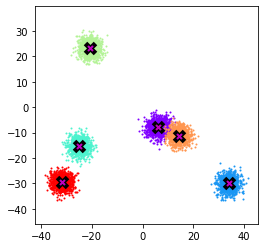

<Figure size 432x288 with 0 Axes>

In [6]:
plot_data(centroids, data, n_samples)

In [7]:
X = meanshift_batch(data, batch_size=200).cpu().numpy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

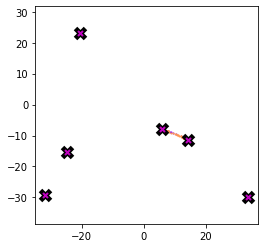

<Figure size 432x288 with 0 Axes>

In [8]:
plot_data(centroids, X, n_samples)

In [17]:
my_meanshift = MeanShift(bandwidth=2.5, max_iter=10, batch_size=100, seeds=None, dist_thresh=0.0001)

In [18]:
data_torch = torch.Tensor(data)
res = my_meanshift.run(data_torch)

0
1
2
3
4
5
6
7
8
9


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

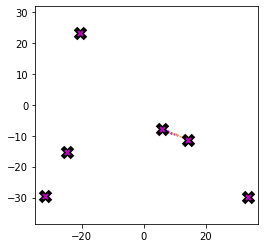

<Figure size 432x288 with 0 Axes>

In [19]:
plot_data(centroids, res.numpy(), n_samples)

In [5]:
dist = distance(data[0], data)
weight = gaussian(dist, 2.5)

In [8]:
weight[:, None].shape

(6000, 1)

In [9]:
data.shape

(6000, 2)

In [10]:
centroids

array([[-25.0673897 , -33.44567134],
       [ 26.79925669,   2.85755502],
       [ 10.23654977,   4.66073824],
       [ -9.01783783, -20.62827219],
       [-14.32822678,  34.64673842],
       [ -7.98501331,  -5.41525537]])

In [13]:
s = slice(0, 10)

In [19]:
(data[s][None, :] - data[:, None]).shape

(6000, 10, 2)